In [1]:
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd
xbd_path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")

In [2]:
from preprocessing.prepare_folder.create_label_masks import create_masks
from utils.visualization.label_to_color import LabelDict

def count_pxls(mask_path):
    row = np.zeros(6,np.uint16)
    count_tup = np.unique(imread(mask_path)[:,:,0],return_counts=True)
    for l,c in zip(count_tup[0],count_tup[1]):
        row[l] = c
    return list(row)

def count_blds(json_path):
    label_dict = json_path.read_json()
    label_count = pd.Series(data=np.zeros(6, dtype=np.uint16), index=LabelDict.labels.keys())
    for building in label_dict['features']['xy']:
        dmg_label = building['properties'].get('subtype')
        if dmg_label in label_count.index:
            label_count[dmg_label] += 1
    row = label_count.tolist()
    return list(row)

#create_masks(xbd_path)
splits_dict = FilePath("/home/mrtc101/Desktop/tesina/repo/main/fakedata/data/splits/raw_splits.json").read_json()
px_rows = []
bld_rows = []
for split_id, dis_dict in splits_dict.items():
    for dis_id, tile_dict in dis_dict.items():
        for tile_id in tile_dict.keys():
            imgs_dict = tile_dict[tile_id]["post"]
            mask_path = FilePath(imgs_dict["mask"])
            json_path = FilePath(imgs_dict["json"])
            px_count = count_pxls(mask_path)
            bld_count = count_blds(json_path)
            px_rows.append([split_id,dis_id,tile_id]+px_count)
            bld_rows.append([split_id,dis_id,tile_id]+bld_count)

In [3]:
bld_Count_df  = pd.DataFrame(bld_rows,columns=["split_id","dis_id","tile_id"]+list(LabelDict().labels.keys()))
bld_Count_df

,split_id,dis_id,tile_id,background,no-damage,minor-damage,major-damage,destroyed,un-classified
0,train,socal-fire,00000756,0,12,0,0,2,5
1,train,socal-fire,00000605,0,10,0,0,0,0
2,train,socal-fire,00001224,0,13,0,0,0,0
3,train,socal-fire,00000854,0,9,0,0,0,3
4,train,socal-fire,00001018,0,12,0,0,0,2
...,...,...,...,...,...,...,...,...,...
1103,test,tuscaloosa-tornado,00000266,0,22,12,3,3,15
1104,test,joplin-tornado,00000066,0,13,3,0,0,0
1105,test,joplin-tornado,00000016,0,10,30,25,94,0
1106,test,joplin-tornado,00000088,0,11,8,4,65,7


In [4]:
px_Count_df  = pd.DataFrame(px_rows,columns=["split_id","dis_id","tile_id"]+list(LabelDict().labels.keys()))
px_Count_df

,split_id,dis_id,tile_id,background,no-damage,minor-damage,major-damage,destroyed,un-classified
0,train,socal-fire,00000756,56640,7628,0,0,1268,0
1,train,socal-fire,00000605,16673,48863,0,0,0,0
2,train,socal-fire,00001224,48983,16553,0,0,0,0
3,train,socal-fire,00000854,49491,16045,0,0,0,0
4,train,socal-fire,00001018,58331,7205,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1103,test,tuscaloosa-tornado,00000266,46207,9786,5840,2241,1462,0
1104,test,joplin-tornado,00000066,54767,63936,12369,0,0,0
1105,test,joplin-tornado,00000016,1705,6707,24766,23080,9278,0
1106,test,joplin-tornado,00000088,385,4074,8784,10943,41350,0


# Bld count per disaster

In [49]:
bld_matrix = bld_Count_df.drop(columns=["background"]).groupby(["split_id","dis_id"]).apply(lambda x: x.sum(axis=0,numeric_only=True),include_groups=False)
bld_matrix["Total"] = bld_matrix.sum(axis=1)

test_total_s = bld_matrix.loc["test"].sum(axis=0)
bld_matrix.loc[("test","Total"),:] = test_total_s

train_total_s = bld_matrix.loc["test"].sum(axis=0)
bld_matrix.loc[("train","Total"),:] = train_total_s

total = bld_matrix.sum(axis=0)
bld_matrix.loc[("Total","-"),:] = total
bld_matrix = bld_matrix.astype(int)
bld_matrix

no-damage  minor-damage  major-damage  \
split_id dis_id                                                       
test     hurricane-florence          55             0             0   
         hurricane-harvey           122           198          1111   
         hurricane-matthew           11           322            35   
         hurricane-michael          181           126            43   
         joplin-tornado              35            45            49   
         lower-puna-volcano          34             0             0   
         midwest-flooding            65             1             5   
         moore-tornado               25            28            24   
         nepal-flooding             107            39           107   
         palu-tsunami               475             0            70   
         pinery-bushfire             78             1             0   
         portugal-wildfire          112             1             2   
         santa-rosa-wildfire         22             2             0   
         socal-fire                  65             0             0   
         sunda-tsunami               10             0             0   
         tuscaloosa-tornado          95           122             4   
         woolsey-fire               116             4             1   
train    guatemala-volcano           42             2             0   
         hurricane-florence         593             9             8   
         hurricane-harvey           698          1722          8125   
         hurricane-matthew          657          8235          1185   
         hurricane-michael          882           673           213   
         joplin-tornado             556           563           400   
         lower-puna-volcano         243            10             0   
         mexico-earthquake           40             0             0   
         midwest-flooding           516            30            13   
         moore-tornado              426           186           159   
         nepal-flooding             477           418           776   
         palu-tsunami              1225             1           190   
         pinery-bushfire            731             9            15   
         portugal-wildfire         1290            14            28   
         santa-rosa-wildfire       1012            35            35   
         socal-fire                1216            15            21   
         sunda-tsunami              122             0             1   
         tuscaloosa-tornado         375           149            38   
         woolsey-fire               775            24            17   
test     Total                     1608           889          1451   
train    Total                     3216          1778          2902   
Total    -                        18308         15651         17028   

                              destroyed  un-classified  Total  
split_id dis_id                                                
test     hurricane-florence           0              2     57  
         hurricane-harvey            18              4   1453  
         hurricane-matthew          150              6    524  
         hurricane-michael           12              4    366  
         joplin-tornado             514              7    650  
         lower-puna-volcano           1              8     43  
         midwest-flooding             1             11     83  
         moore-tornado              197             11    285  
         nepal-flooding               0              5    258  
         palu-tsunami               702             72   1319  
         pinery-bushfire              1             10     90  
         portugal-wildfire            1              7    123  
         santa-rosa-wildfire        351              5    380  
         socal-fire                  75             10    150  
         sunda-tsunami                0              2     12  
         tuscaloosa-tornado   

# pixel count by disaster

In [13]:
px_matrix = px_Count_df.groupby(["split_id","dis_id"]).apply(lambda x: x.sum(axis=0,numeric_only=True),include_groups=False)
px_matrix["Total"] = px_matrix.sum(axis=1)
test_total_s = px_matrix.loc["test"].sum(axis=0)
px_matrix.loc[("test","Total"),:] = test_total_s

train_total_s = px_matrix.loc["test"].sum(axis=0)
px_matrix.loc[("train","Total"),:] = train_total_s

total = px_matrix.sum(axis=0)
px_matrix.loc[("Total","-"),:] = total
px_matrix = px_matrix.astype(int)
px_matrix

background  no-damage  minor-damage  \
split_id dis_id                                                     
test     hurricane-florence       258301      69379             0   
         hurricane-harvey         286164      98705        170146   
         hurricane-matthew        114304       7063         67779   
         hurricane-michael        166312     175226        117279   
         joplin-tornado           111802      76013         49792   
         lower-puna-volcano       184520      11982             0   
         midwest-flooding         349296      38753          1749   
         moore-tornado             63905      34053         31600   
         nepal-flooding            71588      21611         11275   
         palu-tsunami             259368     202780             0   
         pinery-bushfire          417864      40431           248   
         portugal-wildfire        583515      70044           764   
         santa-rosa-wildfire      156105      33112          2870   
         socal-fire               289708      51607             0   
         sunda-tsunami             58244       7292             0   
         tuscaloosa-tornado       126477     107883         22882   
         woolsey-fire             490383      74003          3370   
train    guatemala-volcano        212760      48905           479   
         hurricane-florence      3052497     526758         10045   
         hurricane-harvey        2480539     729489       1237797   
         hurricane-matthew       1363037     272334        949419   
         hurricane-michael       1097755     765552        521611   
         joplin-tornado           822572     292755        447625   
         lower-puna-volcano      1267603     117985          6081   
         mexico-earthquake        174980      87164             0   
         midwest-flooding        2755421     355927         14414   
         moore-tornado            831283     356226        192291   
         nepal-flooding           902949     214589        143378   
         palu-tsunami            1097301     427125           833   
         pinery-bushfire         3979334     445279          6163   
         portugal-wildfire       6402054     849765          4816   
         santa-rosa-wildfire     2332776     976984         53978   
         socal-fire              4580103    1271415         11476   
         sunda-tsunami            580193     139004             0   
         tuscaloosa-tornado      1071604     455114        149060   
         woolsey-fire            3056010     546249         13555   
test     Total                   3987856    1119937        479754   
train    Total                   7975712    2239874        959508   
Total    -                      54012195   13358367       5682037   

                              major-damage  destroyed  un-classified     Total  
split_id dis_id                                                                 
test     hurricane-florence              0          0              0    327680  
         hurricane-harvey           338053      24436              0    917504  
         hurricane-matthew           22958      50040              0    262144  
         hurricane-michael           56367       9104              0    524288  
         joplin-tornado              50910     104699              0    393216  
         lower-puna-volcano              0        106              0    196608  
         midwest-flooding             3361         57              0    393216  
         moore-tornado               25814      41236              0    196608  
         nepal-flooding              26598          0              0    131072  
         palu-tsunami                90220     168528              0    720896  
         pinery-bushfire                 0        209              0    458752  
         portugal-wildfire             830        207              0    655360  
         santa-rosa-wildfire             0      70057             

# Predicted weights

In [14]:
pxsum = px_matrix.loc[("Total","-")][:5]
weights = pxsum.sum() / pxsum
weights

background       1.591923
no-damage        6.436657
minor-damage    15.132466
major-damage    12.907077
destroyed       13.715794
Name: (Total, -), dtype: float64

# distribution of buildings per tile

array([[<Axes: title={'center': 'no-damage'}>,
        <Axes: title={'center': 'minor-damage'}>],
       [<Axes: title={'center': 'major-damage'}>,
        <Axes: title={'center': 'destroyed'}>]], dtype=object)

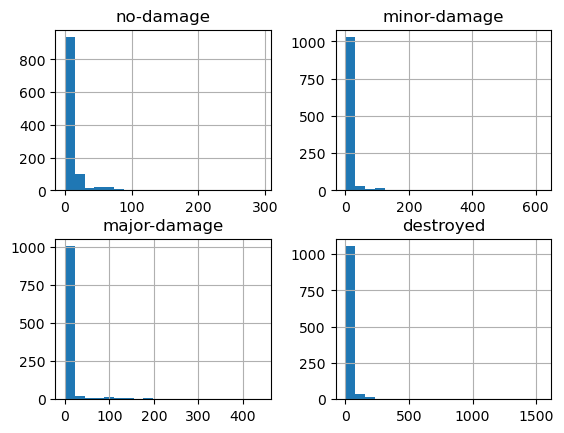

In [46]:
bld_Count_df.set_index(["split_id","dis_id","tile_id"]).drop(columns=["background","un-classified"]).hist(bins=20)

# distribution of pixels per tile

array([[<Axes: title={'center': 'no-damage'}>,
        <Axes: title={'center': 'minor-damage'}>],
       [<Axes: title={'center': 'major-damage'}>,
        <Axes: title={'center': 'destroyed'}>]], dtype=object)

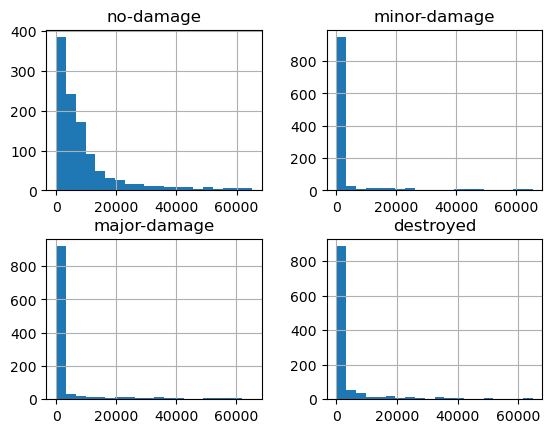

In [47]:
px_Count_df.set_index(["split_id","dis_id","tile_id"]).drop(columns=["background","un-classified"]).hist(bins=20)

# Disaster Sum

In [59]:
bld_Count_df.value_counts("split_id")

split_id
train    998
test     110
Name: count, dtype: int64

In [60]:
bld_matrix["Total"]


split_id  dis_id             
test      hurricane-florence        57
          hurricane-harvey        1453
          hurricane-matthew        524
          hurricane-michael        366
          joplin-tornado           650
          lower-puna-volcano        43
          midwest-flooding          83
          moore-tornado            285
          nepal-flooding           258
          palu-tsunami            1319
          pinery-bushfire           90
          portugal-wildfire        123
          santa-rosa-wildfire      380
          socal-fire               150
          sunda-tsunami             12
          tuscaloosa-tornado       242
          woolsey-fire             159
train     guatemala-volcano         44
          hurricane-florence       643
          hurricane-harvey       11042
          hurricane-matthew      10869
          hurricane-michael       1875
          joplin-tornado          3171
          lower-puna-volcano       450
          mexico-earthquake       